# **SIFT Algorithm:**
* **Steps:**
    1. Scale-space Extrema Detection:
        * Scale Space and Image Pyramids
        * Finding Scale Space Extrema
    2. Keypoint Localization
    3. Orientation Assignment
        * Keypoints Orientation 
        * Cleaning Up Keypoints
    4. Keypoint Descriptor

In [81]:
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
import matplotlib.pyplot as plt
from functools import cmp_to_key
import cv2
from cv2 import KeyPoint
import numpy as np

### **1. Scale-space Extrema Detection:**
#### 1. Scale Space and Image Pyramids
1. Generate the base image by doubling the size of the input image and blurring it with a Gaussian kernel.

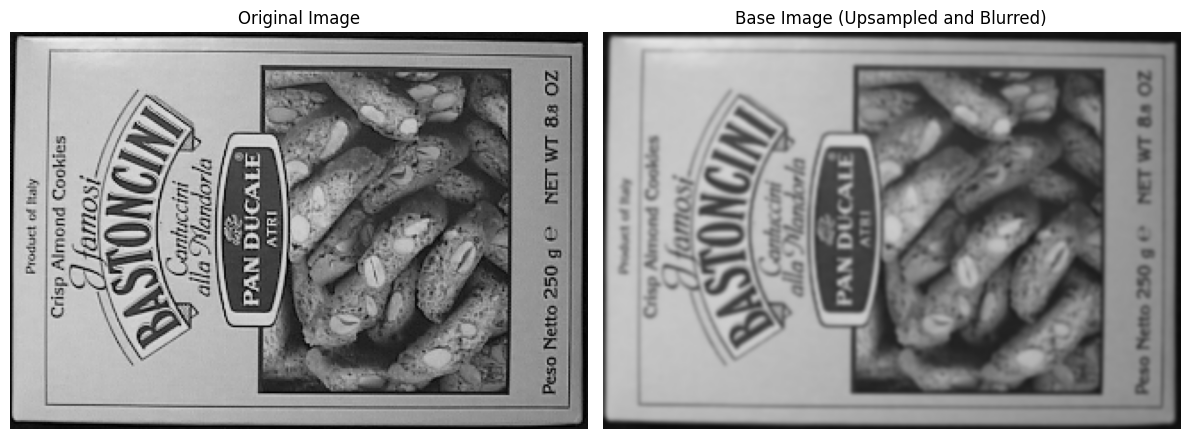

Original image shape: (223, 324, 3)
Base image shape: (446, 648, 3)


In [82]:
def generateBaseImage(image, sigma, assumed_blur):
    image = cv2.resize(image, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    return cv2.GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)

# Test
image = cv2.imread('data/box.png')
base_image = generateBaseImage(image, 2, 0.05)

# Convert BGR to RGB for matplotlib display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
base_image_rgb = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

# Display the images side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Base Image (Upsampled and Blurred)')
plt.imshow(base_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

# Print image shapes to see the size difference
print(f"Original image shape: {image.shape}")
print(f"Base image shape: {base_image.shape}")

2. Calculate the number of actaves whitch is the number of times we can repeatedly halve an image until it becomes too small (has a side length of at least 1 pixel)
    * Mathematical Formulation:
        * If y is the minimum dimension of the image (height or width)
        * And we halve it x times
        * Then we get: y / 2^x = 1 (where 1 is the minimum size in pixels)
        * Solving for x: x = log(y) / log(2)*
    * The -1 Adjustment:
        * This subtraction of 1 ensures that the smallest image in the pyramid has a minimum dimension of at least 2 pixels
        * Actually, it ensures a minimum dimension of about 2, which `round`s to 3 pixels when implemented

In [83]:
def computeNumberOfOctaves(image_shape):
    return int(round(log(min(image_shape)) / log(2) - 1))

# Test with different image sizes
# Test 1: A small image
small_shape = (64, 64)
print(f"For image shape {small_shape}, number of octaves = {computeNumberOfOctaves(small_shape)}")

# Test 2: A medium image
medium_shape = (256, 512)
print(f"For image shape {medium_shape}, number of octaves = {computeNumberOfOctaves(medium_shape)}")

# Test 3: A large image
large_shape = (1024, 768)
print(f"For image shape {large_shape}, number of octaves = {computeNumberOfOctaves(large_shape)}")

# Test 4: Using a real image
# image = cv2.imread('data/einstain 3.jfif')
if image is not None:
    print(f"For Einstein image with shape {image.shape}, number of octaves = {computeNumberOfOctaves(image.shape[:2])}")
else:
    print("Could not load the image. Please check the path.")

For image shape (64, 64), number of octaves = 5
For image shape (256, 512), number of octaves = 7
For image shape (1024, 768), number of octaves = 9
For Einstein image with shape (223, 324, 3), number of octaves = 7


3. Generate the Gaussian pyramid by repeatedly applying Gaussian blur and downsampling to the base image.
    * In SIFT, we need `num_intervals + 3` images per octave because:
        * We need num_intervals + 1 images to create num_intervals DoG (Difference of Gaussian) images
        * We need 2 additional images that will be used for extrema detection at the boundaries of the octave
    * Calculating k = 2^(1/num_intervals) ensures that:
        * After num_intervals steps, the scale exactly doubles (k^num_intervals = 2)
        * This creates a consistent logarithmic sampling of the scale space
        * It allows for smooth transitions between octaves
        * The scale space is properly sampled to detect features at all scales
    * `sigma_previous = (k^(image_index-1)) * sigma`: The total blur of the previous image
    * `sigma_total = k * sigma_previous`: The total blur needed for the current image
    * `gaussian_kernels[image_index] = sqrt(sigma_total^2 - sigma_previous^2)`: The additional blur needed
    * We halve the third-to-last image, since this has the appropriate blur we want, and use this to begin the next layer.

In [84]:
def generateGaussianKernels(sigma, num_intervals):
    num_images_per_octave = num_intervals + 3
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = zeros(num_images_per_octave)  
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

# Test
gaussian_kernels = generateGaussianKernels(1.6, 3)
print(gaussian_kernels)

[1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]


In [85]:
def generateGaussianImages(image, num_octaves, gaussian_kernels):
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        # first image in octave already has the correct blur
        gaussian_images_in_octave.append(image)  
        for gaussian_kernel in gaussian_kernels[1:]:
            image = cv2.GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = cv2.resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=cv2.INTER_NEAREST)
    return gaussian_images

4. Generate the DoG images by subtracting successive pairs of these Gaussian-blurred images.

In [86]:
def generateDoGImages(gaussian_images):
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(second_image.astype(float) - first_image.astype(float)) 
        dog_images.append(dog_images_in_octave)
    return dog_images

#### Plotting Third octave of the Gaussain images and the DoG images

Number of octaves: 8
Number of octaves generated: 8


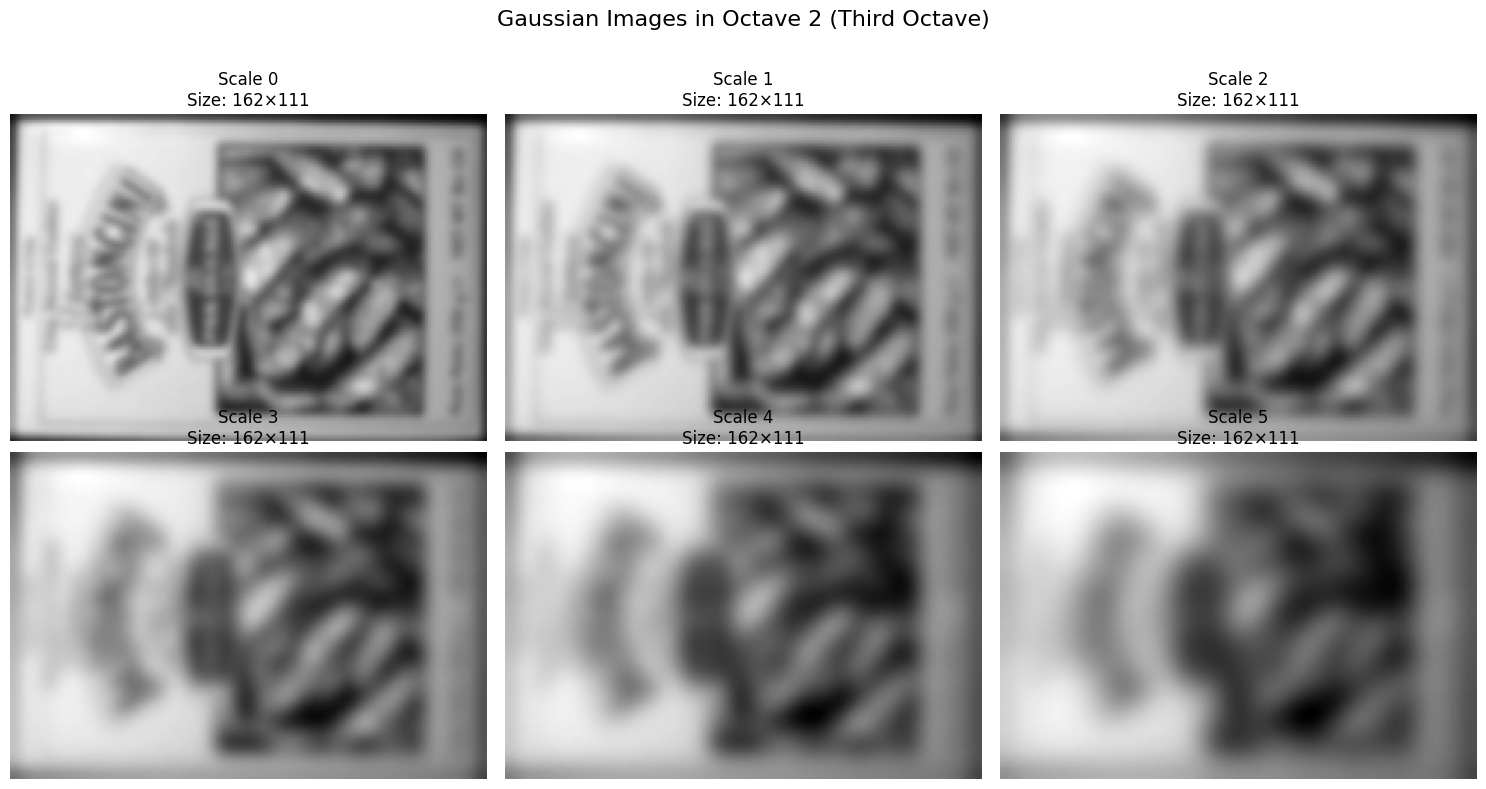

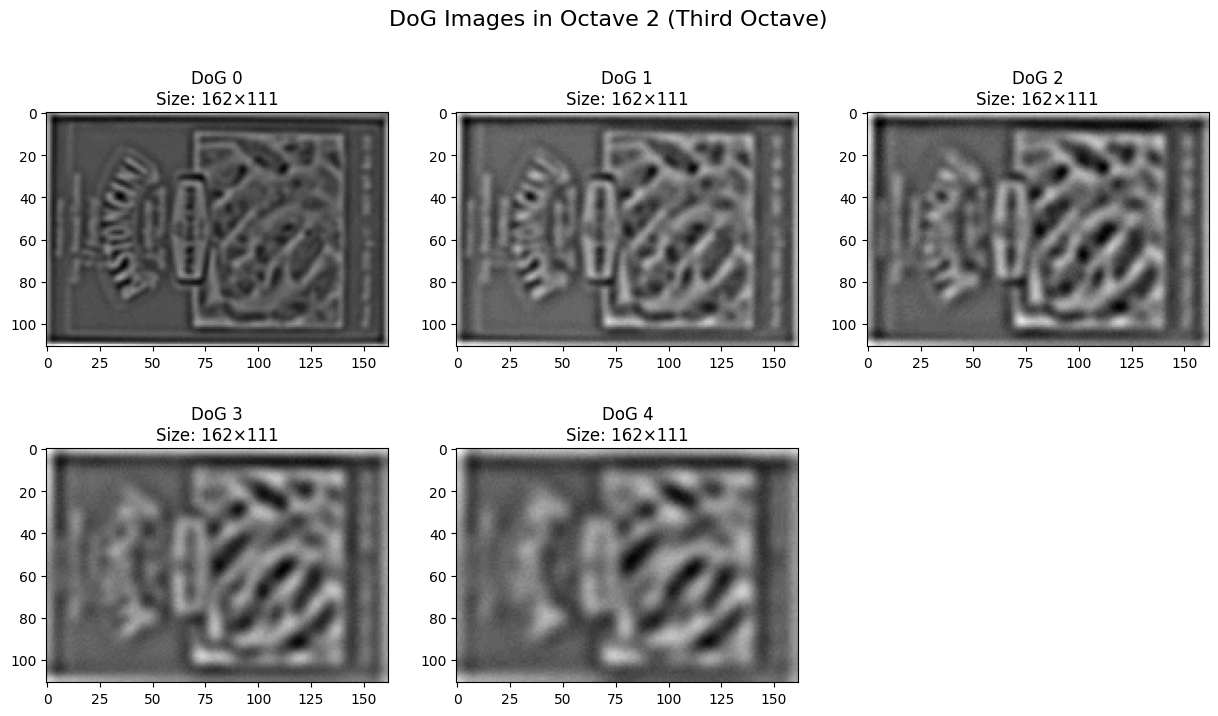

In [87]:
# Test gaussian images and DoG images
image = cv2.imread('data/box.png', cv2.IMREAD_GRAYSCALE)  
if image is not None:
    # Set parameters
    sigma = 1.6
    assumed_blur = 0.5
    num_intervals = 3
    
    # Generate base image
    base_image = generateBaseImage(image, sigma, assumed_blur)
    
    # Compute number of octaves
    num_octaves = computeNumberOfOctaves(base_image.shape)
    print(f"Number of octaves: {num_octaves}")
    
    # Generate Gaussian kernels
    gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
    
    # Generate Gaussian images
    gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    print(f"Number of octaves generated: {len(gaussian_images)}")
    
    # Generate DoG images
    dog_images = generateDoGImages(gaussian_images)
    
    # Check if we have at least 3 octaves
    if len(gaussian_images) > 2:
        # Plot the third octave of Gaussian images
        third_octave_gaussian = gaussian_images[2]
        
        plt.figure(figsize=(15, 8))
        plt.suptitle('Gaussian Images in Octave 2 (Third Octave)', fontsize=16)
        
        for i, img in enumerate(third_octave_gaussian):
            plt.subplot(2, 3, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Scale {i}\nSize: {img.shape[1]}×{img.shape[0]}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()
        
        # Plot the third octave of DoG images
        third_octave_dog = dog_images[2]
        
        plt.figure(figsize=(15, 8))
        plt.suptitle('DoG Images in Octave 2 (Third Octave)', fontsize=16)
        
        for i, img in enumerate(third_octave_dog):
            plt.subplot(2, 3, i+1)
            # Normalize DoG images for better visualization
            img_normalized = (img - img.min()) / (img.max() - img.min())
            plt.imshow(img_normalized, cmap='gray')
            plt.title(f'DoG {i}\nSize: {img.shape[1]}×{img.shape[0]}')

#### 2. Finding Scale Space Extrema:
1. In each triplet of images in each octave, we look for pixels in the middle image that are greater than or less than all of their 26 neighbors: 8 neighbors in the middle image, 9 neighbors in the image below, and 9 neighbors in the image above.
    * Function Parameters
        * first_subimage: A 3×3 patch from the previous scale (DoG image)
        * second_subimage: A 3×3 patch from the current scale, centered on the pixel being examined
        * third_subimage: A 3×3 patch from the next scale (DoG image)
        * threshold: A minimum absolute value threshold to filter out weak extrema
    * Scale s-1    Scale s      Scale s+1
    
            [1st layer]  [2nd layer]  [3rd layer]

            * * *        * * *        * * *
            * * *        * X *        * * *
            * * *        * * *        * * *

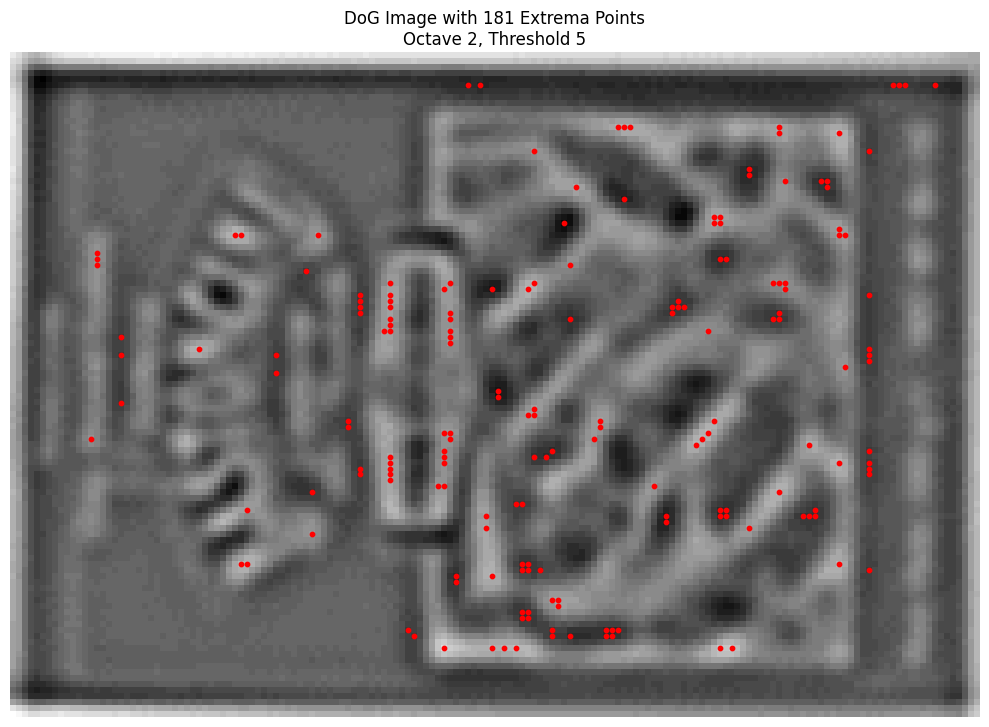

Found 181 extrema points in DoG images 1-3 of octave 2


In [88]:
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

# Test
# Get the DoG images from the specified octave
dog_octave = dog_images[2]

# Get the first three DoG images
first_image = dog_octave[0]
second_image = dog_octave[1]
third_image = dog_octave[2]

# Lists to store coordinates of extrema points
extrema_coords = []

# Define border width to avoid edge effects
border_width = 5

# Scan through each pixel (excluding borders)
for row in range(border_width, second_image.shape[0] - border_width):
    for col in range(border_width, second_image.shape[1] - border_width):
        # Extract 3x3 patches
        first_patch = first_image[row-1:row+2, col-1:col+2]
        second_patch = second_image[row-1:row+2, col-1:col+2]
        third_patch = third_image[row-1:row+2, col-1:col+2]
        
        # Check if it's an extremum
        if isPixelAnExtremum(first_patch, second_patch, third_patch, threshold=5):
            extrema_coords.append((row, col))

# Create a figure to display the result
plt.figure(figsize=(10, 8))

# Display the middle image with extrema points
plt.imshow(second_image, cmap='gray')

# Plot extrema points as red dots
if extrema_coords:
    extrema_coords = np.array(extrema_coords)
    plt.scatter(extrema_coords[:, 1], extrema_coords[:, 0], c='red', s=10, marker='o')

plt.title(f'DoG Image with {len(extrema_coords)} Extrema Points\nOctave {2}, Threshold {5}')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Found {len(extrema_coords)} extrema points in DoG images 1-3 of octave {2}")


### **2. Keypoints Localization:**

In [89]:
def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        # need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's thresholds
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube)
        hessian = computeHessianAtCenterPixel(pixel_cube)
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        # make sure the new pixel_cube will lie entirely within the image
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

def computeGradientAtCenterPixel(pixel_array):
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

In [93]:
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    float_tolerance = 1e-7
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

2. This function finds the important points (keypoints) in an image that SIFT will use for matching. Here's what it does in simple words 
* Scans through the image pyramid: It looks at every pixel in each DoG (Difference of Gaussian) image across all scales and octaves.

* Finds special points: It identifies pixels that are either brighter or darker than all their neighbors in 3D space (across position and scale).

* Filters out weak points: It ignores points that aren't strong enough (low contrast) to be reliable.

* Refines point locations: It uses math to pinpoint the exact position of each point with sub-pixel accuracy.

* Removes edge points: It filters out points that lie on edges, which aren't as distinctive as corner-like features.

* Assigns directions: For each remaining point, it determines one or more orientations based on how the brightness changes around that point.

* Builds a list: It collects all these special points with their positions, scales, and orientations.

In [94]:
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)

C:\Users\Compu House\AppData\Local\Temp\ipykernel_8804\1438091513.py:18: RuntimeWarning: overflow encountered in scalar subtract
  dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
C:\Users\Compu House\AppData\Local\Temp\ipykernel_8804\1438091513.py:20: RuntimeWarning: overflow encountered in scalar multiply
  gradient_magnitude = sqrt(dx * dx + dy * dy)
C:\Users\Compu House\AppData\Local\Temp\ipykernel_8804\1438091513.py:19: RuntimeWarning: overflow encountered in scalar subtract
  dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
C:\Users\Compu House\AppData\Local\Temp\ipykernel_8804\1438091513.py:20: RuntimeWarning: overflow encountered in scalar add
  gradient_magnitude = sqrt(dx * dx + dy * dy)


No keypoints were detected. Check your findScaleSpaceExtrema function.


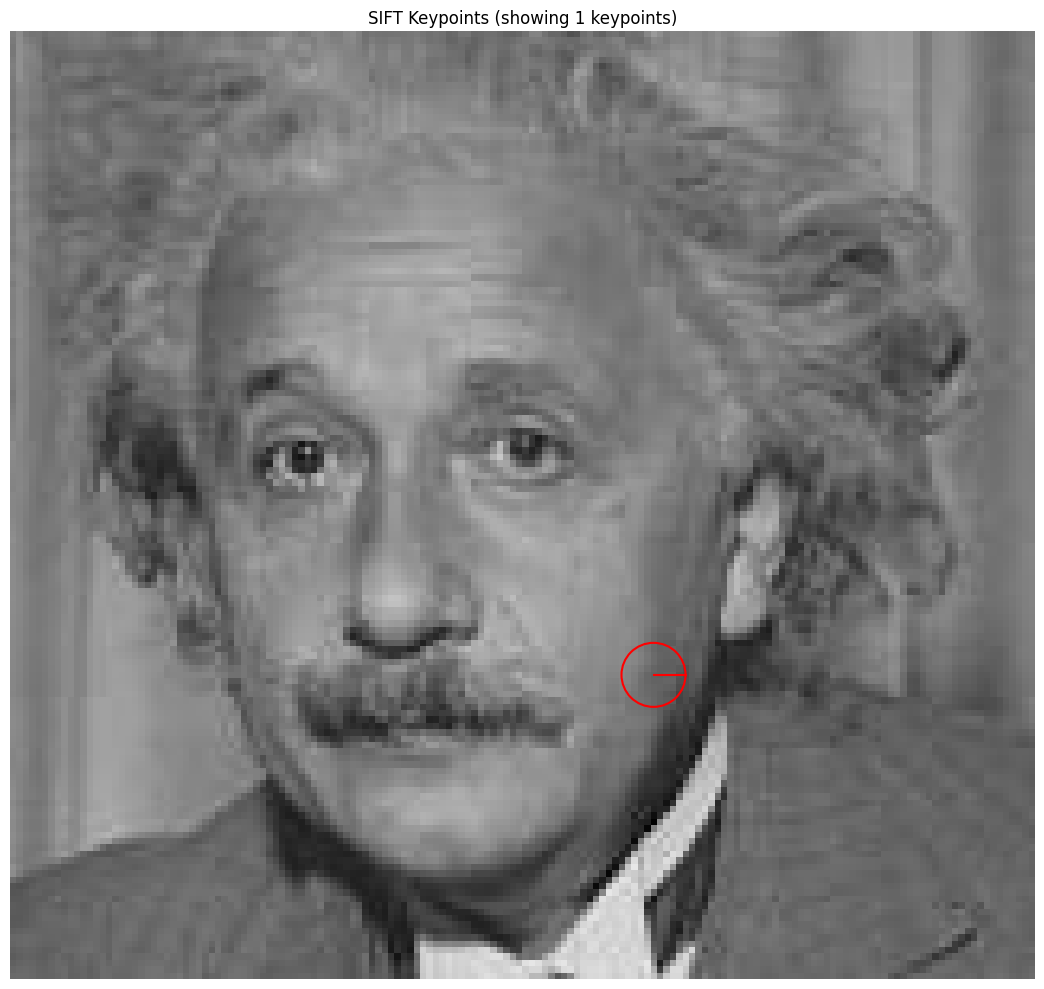

Displayed 1 keypoints


In [ ]:
# Visualize keypoints on the original image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_keypoints_on_image(image, keypoints, num_keypoints=None):
    """
    Visualize SIFT keypoints on the original image.
    
    Parameters:
    - image: The original image
    - keypoints: List of keypoints detected by SIFT
    - num_keypoints: Number of keypoints to display (None for all)
    """
    # Convert grayscale to RGB for colored visualization if needed
    if len(image.shape) == 2:
        display_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        display_image = image.copy()
    
    # Sort keypoints by response (strongest first)
    sorted_keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)
    
    # Limit number of keypoints to display if specified
    if num_keypoints is not None:
        sorted_keypoints = sorted_keypoints[:num_keypoints]
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Display the image
    plt.imshow(display_image, cmap='gray' if len(image.shape) == 2 else None)
    
    # Create a plot with circles for keypoints
    ax = plt.gca()
    
    # Plot each keypoint
    for kp in sorted_keypoints:
        # Get keypoint coordinates
        x, y = kp.pt
        # Get keypoint size (scale)
        size = kp.size
        
        # Draw circle at keypoint location with radius proportional to keypoint size
        circle = Circle((x, y), size/2, fill=False, edgecolor='red', linewidth=1.5)
        ax.add_patch(circle)
        
        # Draw a line indicating orientation if available
        if hasattr(kp, 'angle') and kp.angle is not None:
            angle_rad = np.deg2rad(kp.angle)
            dx = np.cos(angle_rad) * size/2
            dy = np.sin(angle_rad) * size/2
            plt.plot([x, x+dx], [y, y+dy], 'r-', linewidth=1.5)
    
    plt.title(f'SIFT Keypoints (showing {len(sorted_keypoints)} keypoints)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Displayed {len(sorted_keypoints)} keypoints")

# Example usage:
# First, you need to detect keypoints using the SIFT algorithm

# Modify your code to check if keypoints is None
# Load the original image
original_image = cv2.imread('data/box.png', cv2.IMREAD_GRAYSCALE)

# Set parameters
sigma = 1.6
assumed_blur = 0.5
num_intervals = 3
image_border_width = 5

# Generate base image
base_image = generateBaseImage(original_image, sigma, assumed_blur)

# Compute number of octaves
num_octaves = computeNumberOfOctaves(base_image.shape)

# Generate Gaussian kernels
gaussian_kernels = generateGaussianKernels(sigma, num_intervals)

# Generate Gaussian images
gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)

# Generate DoG images
dog_images = generateDoGImages(gaussian_images)

# Find keypoints
keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)

# Check if keypoints is None or empty
if keypoints is None or len(keypoints) == 0:
    print("No keypoints were detected. Check your findScaleSpaceExtrema function.")
    # Create a dummy keypoint for testing visualization
    from cv2 import KeyPoint
    keypoints = [KeyPoint(x=100, y=100, size=10, angle=0, response=1, octave=0, class_id=-1)]
else:
    print(f"Found {len(keypoints)} keypoints")

# Visualize keypoints on the original image
visualize_keypoints_on_image(original_image, keypoints, num_keypoints=100)  # Show top 100 keypoints

## **References:** 
* [Link to the paper](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf)
* [Link to the article part 1](https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-1-306a99b50aa5) 
* [Link to the article part 2](https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-2-c4350274be2b)